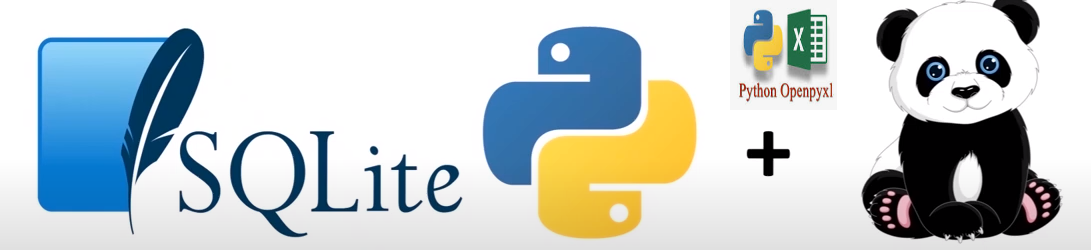

# Spreadsheet Prettifcation -  By Joe Eberle - 10/12/2022

### Optional Precursor Step  - Import Dependent Python Libraries  (If Not Installed) 
#####  PIP Install any Python Libraries below that you dont already have installed 

In [1]:
# PIP Install any Python Libraries you dont already have installed 
#!pip install pyttsx3
#!pip install pandas    ## Note you SHOULD NOT NEED TO DO THIS !!!! Pandas is part of python anaconda install 
#!pip install pyodbc
#!pip install pysqlite3   ## Note you SHOULD NOT NEED TO DO THIS !!!! SQL Lite is part of python
#!pip install openpyxl    

In [44]:
# Import the necessary Libraries 
import sqlite3
import glob, os
import pandas as pd 
from pathlib import Path
import pyttsx3
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
import openpyxl 
from openpyxl.styles import PatternFill
import random
import math
import os
import glob
from openpyxl import load_workbook
from openpyxl.styles import colors
from openpyxl.utils import get_column_letter
from openpyxl.styles import NamedStyle, Font, Border, Side, PatternFill, GradientFill, Alignment, Color, Fill
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows 
from openpyxl.formatting.rule import DataBarRule
from openpyxl.formatting.rule import ColorScaleRule
import openpyxl 
import time

 
# Establish some import parameters 
importing_xlsx_files = False 
importing_csv_files = True 
Data_Import_Starting_Directory = 'Y:/_Kaleida_Input/'
Path_to_Raw_Data = 'J:/OPA/GLIN Reporting Data Services Output/GPPC Scorecards/'
#Data_Import_Starting_Directory = 'C:/Data/'
Process_Name = 'Importing CSV data into SQL'

step_debugging = True
detail_debugging = True
Process_Step_Name = ''  
Reading_Intro = True
Reading_Credits =  False
Reading_Steps = True 
Reading_Terms = True 
printing_output = True
Talking_Code = True
Talking_Voice_Male_Gender = True        # Set to False for Female Voice 
Code_Logging  = True 
event_log_row = 0 

# Create some Global Variables for SQL Constructs 
Table_Name_Extension_Daily = '_DI'
Table_Name_Extension_Historical = '_HX'
Table_Name_Extension_Administrative = '_AD'
Table_Name_Prefix = '[pbic_1_0].'
  
Text_to_Speech = pyttsx3.init()
 

In [17]:
global Talking_Code
global import_directory_file_Number 
global event_log_row 
global printing_output


def set_up_python_infrastructure():
    initialize_replacement_Dictionaries()    # Set up control libraries for syntactic Consistency 
    Initialize_Text_to_Speach()              # Intitialize Text to Speech Engine 
    df_e_log = create_event_log_dataframe()  # Set up the Event Logging 
    
# Say Whatever the user wants 
def say(speech):
    if Talking_Code:
        Text_to_Speech.say(speech)
        Text_to_Speech.runAndWait()    
    
# Intitialize Text to Speech Engine 
def Initialize_Text_to_Speach():
    Text_to_Speech = pyttsx3.init()
    Text_to_Speech.setProperty('Rate',187)
    voices = Text_to_Speech.getProperty('voices')
    if Talking_Voice_Male_Gender:
        Text_to_Speech.setProperty('voice', voices[0].id)    # Default Male voice registered as 'Dave'
    else: 
        Text_to_Speech.setProperty('voice', voices[1].id)    # Alternate Female voice registered as 'Tina'
    speech = 'The text to speech engine is initialized using pythons pyttsx3 engine'
    Text_to_Speech.say(speech)
    Text_to_Speech.runAndWait()    
    
    
# Say Whatever the user wants 
def say(speech):
    Text_to_Speech.say(speech)
    Text_to_Speech.runAndWait()       
    
# Create dataframe to house Directories 
def create_directory_dataframe():
    df_import_directories = pd.DataFrame(columns = ('Root_Directory','Sub_Directory'))
    return df_import_directories  

def create_import_files_dataframe():
    df_import_files = pd.DataFrame(columns = ('Root_Directory','Sub_Directory','Table_Name','File_Name'))
    return df_import_files  

def add_import_directory(Root_Directory,Sub_Directory):
    global import_directory_file_Number 
    import_directory_file_Number += 1  
    df_import_directories.loc[import_directory_file_Number] = [Root_Directory,Sub_Directory]
    return import_directory_file_Number 

def add_import_File(Root_Directory,Sub_Directory,Table_Name,File_Name):
    global import_file_Number 
    import_file_Number += 1  
    df_import_files.loc[import_file_Number] = [Root_Directory,Sub_Directory,Table_Name,File_Name]
    return import_directory_file_Number  

# Create dataframe to house Directories 
def create_event_log_dataframe():
    df_event_log = pd.DataFrame(columns = ('Event_ID','Process_Name','Event_Name','Event_Date','Event_Time','Task_Start_Time','Task_End_Time','TASk_Duration','Comments'))
    return df_event_log


df_event_log = create_event_log_dataframe()

# Create dataframe to database schema 
def create_database_schema_dataframe():
    df_schema = pd.DataFrame(columns = ('Database_Name','Table_Name','Column_Number','Column_Name','Column_Data_Type','Column_Sample_Data','Column_Description'))
    return df_schema

# Create dataframe to house Directories 
def add_log_event(Process_Name,Event_Name,Event_Date,Event_Time,Task_Start_Time,Task_End_Time, Task_Duration , Comments ):
    global event_log_row  
    event_log_row += 1  
    df_event_log.loc[event_log_row] = [event_log_row,Process_Name,Event_Name,Event_Date,Event_Time,Task_Start_Time,Task_End_Time, Task_Duration , Comments]

    
# Add Log Events 
def add_log_event_timer(Process_Name,Event_Name,Event_Date,Event_Time,Task_Start_Time,Task_End_Time, Task_Duration , Comments ):
    global event_log_row  
    event_log_row += 1  
    Event_Date = date.today()
    Event_Time = time.time() 
    df_event_log.loc[event_log_row] = [event_log_row,Process_Name,Event_Name,Event_Date,Event_Time,Task_Start_Time,Task_End_Time, Task_Duration , Comments]
    
# Reset the Event timer start time 
def reset_event_timer(Process_Name,Event_Name,Event_Date,Event_Time,Task_Start_Time,Task_End_Time, Task_Duration , Comments ):
    global event_log_row  
    event_log_row += 1  
    Event_Date = date.today()
    Event_Time = time.time() 
    Task_Start_Time    = time.time()  
    df_event_log.loc[event_log_row] = [event_log_row,Process_Name,Event_Name,Event_Date,Event_Time,Task_Start_Time,Task_End_Time, Task_Duration , Comments]

    # Get a list of all the Subfiles to iterate through 
def list_all_csv_files(path):
    extension = 'csv'
    os.chdir(path)
    print('CSV Files to Import from Directory:', path)
    csv_file_count = 0
    for file in glob.glob('*.{}'.format(extension)):
        csv_file_count += 1 
        out('CSV File #{} filename: {}  '.format(str(csv_file_count),file))
        
    # Get a list of all the Subfiles to iterate through 
def register_all_csv_files_for_import(path, table_name):
    extension = 'csv'
    os.chdir(path)
    print('CSV Files to Import from Directory:', path)
    csv_file_count = 0
    for file in glob.glob('*.{}'.format(extension)):
        csv_file_count += 1 
        out('CSV File #{} filename: {}  '.format(str(csv_file_count),file)) 
        file_Number = add_import_File(path,path,table_name,file)
        
def create_import_files_dataframe():
    df_import_files = pd.DataFrame(columns = ('Root_Directory','Sub_Directory','Table_Name','File_Name'))
    return df_import_files  

def add_import_directory(Root_Directory,Sub_Directory):
    global import_directory_file_Number 
    import_directory_file_Number += 1  
    df_import_directories.loc[import_directory_file_Number] = [Root_Directory,Sub_Directory]
    return import_directory_file_Number 

def add_import_File(Root_Directory,Sub_Directory,Table_Name,File_Name):
    global import_file_Number 
    import_file_Number += 1  
    df_import_files.loc[import_file_Number] = [Root_Directory,Sub_Directory,Table_Name,File_Name]
    return import_directory_file_Number          
     
def infer_table_name_from_path(path):
    table_name = path.replace(Data_Import_Starting_Directory,"").replace(' ','_').replace('/','').replace('\\','')
    return table_name 
        
# Introduction - Overview of CSV to SQL Import Process Steps 
def read_credits(): 
    Dialog = 'This Jupiter Notebook Was  : '
    Dialog = Dialog + 'Developed in Python 3 by Joe Eberle  '
    Dialog = Dialog + 'Developed in Python starting on 10/12/2022 '
    Dialog = Dialog + 'This package is free AND Open Source and the code is openly available for general Use. '    
    say(Dialog)         
    
# Introduction - Overview of CSV to SQL Import Process Steps 
def read_terms(): 
    Dialog = 'The terminology for this introduction is : '
    Dialog = Dialog + 'Python. Python is a general-purpose programming language that is widely used for data science.  '
    Dialog = Dialog + 'Structured Query Language (SQL) is one of the worlds most widely used programming languages for manipulating and querying data. '
    Dialog = Dialog + 'PANDAS. Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.  '
    Dialog = Dialog + 'open pie xl is a Python library to read write Excel 2010 xlsx files. It was born from lack of existing library to read/write natively from Python. ' 
    Dialog = Dialog + 'prettification is NOT a real technical term. It is completely made up by the Author. Feel Free to make up your own words. ' 
    say(Dialog)  
    
# Process Steps - Overview of CSV to SQL Import Process Steps 
def read_process_steps():
    Dialog = 'The data flow for this excel prettification is : '
    Dialog = Dialog + 'Step 1: Import a Spreadsheet into python. '
    Dialog = Dialog + 'Step 2: Make the spreadsheet labels and columns easier to understand  '
    Dialog = Dialog + 'Step 3: Format The spreadsheet so it is easier to use with filters etc. '    
    Dialog = Dialog + 'Step 4: Format The spreadsheet with colors and conditional formatting. '
    say(Dialog)    
    
    
# Introduction - Overview of NoteBooks  
def read_introduction():
    Dialog = 'This jupiter notebook will provide an example of spreadsheet automation through python. '
    Dialog = Dialog + 'The resulting spreadsheet will be prettier and easier to use.  '  
    Dialog = Dialog + 'This code will automate a bunch of boring, time consuming and repetitive tasks that people often forget to do.  '    
    say(Dialog)  
    
    
def column_create_SQL (import_df):
    column_name_List = [x.title() for x in import_df.columns] # Create a List of Columns 
    column_Str =  (', '.join(column_name_List)) # Convert List into one String with commas 
    out('Columns =',column_Str)  
    return column_Str            
    
    
def out(dialog):
        if printing_output: 
            print(dialog) 
        if Talking_Code:
            say(dialog)     
        
def list_all_xlsx_files(path):
    extension = 'xlsx'
    os.chdir(path)
    csv_file_count = 0
    for file in glob.glob('*.{}'.format(extension)):
        csv_file_count += 1 
        out('File #{}   is {} '.format(csv_file_count,file))     \
        
        
def explain_the_project():
    if Reading_Intro:
        read_introduction()
    if Reading_Credits:    
        read_credits() 
    if Reading_Steps:
        read_process_steps()
    if Reading_Terms:
        read_terms()        
        
        
        
def convert_data_types(input_df):
    column_datatype_str = str(input_df.dtypes)
    column_datatype_str =  column_datatype_str.replace('dtype: object','').replace('object','varchar[255], ').replace('datetime64[ns]','timestamp, ').replace('float64','float, ')
    out('create column SQL string: {} \n'.format(column_datatype_str))        
        
def read_and_clean_file(data_folder, filename):

    print('Import File =', filename)                 
    df_input_csv = pd.read_csv(filename, nrows=10)
    out('Reading Dataframe Columns before cleanups:{}'.format(df_input_csv.columns))
    df_input_csv.columns = df_input_csv.columns.map('^'.join)
    df_input_csv.columns  = [x.strip().title().replace("^","").replace(" ","_").replace("#","Number").replace("#","Number").replace("%","Percentage") \
                             .replace('_Unnamed','').replace('Unnamed','').replace('Unnamed:','').replace('_Level','').replace("$","Dollar") \
                             .replace('_1','').replace('_2','').replace('_3','').replace('_4','').replace('_5','')  \
                             .replace('_6','').replace('_7','').replace('_8','').replace('_9','')  \
                             .replace('1','').replace('2','').replace('3','').replace('4','').replace('5','')  \
                             .replace('6','').replace('7','').replace('8','').replace('9','').replace('0','')  \
                             .replace('_0','').replace(':7','').replace(':8','').replace(':','').replace('Unnamed: ','')  \
                             for x in df_input_csv.columns]
    return df_input_csv    
 
        
    
def set_up_python_infrastructure():
    initialize_replacement_Dictionaries()    # Set up control libraries for syntactic Consistency 
    Initialize_Text_to_Speach()              # Intitialize Text to Speech Engine 
    df_event_log = create_event_log_dataframe()  # Set up the Event Logging to house the events of this process 
    create_database_schema_dataframe()       # Set up the Database Schema dataframe to house the schema

## Optional - Get an Explanation of the project 

In [38]:
LIGHT_BLUE = "C5D9F1"
YELLOW = "FFFF00"
GRAY = "E4DFEC"
DEEP_BLUE = "1072BA"
DEEP_BLUE2 = "4A9CD9"
WHITE = "FFFFFF"
Green_Good  = "85F386"
Purple_Perfect = "E951F6"
Yellow_OK = "F7F173" 
Gray_None = "696968"  
Red_Bad = "E8241B" 

Yellow_OK_Fill = PatternFill(start_color = Yellow_OK, end_color = Yellow_OK, fill_type = "solid")
Purple_Perfect_Fill = PatternFill(start_color = Purple_Perfect, end_color = Purple_Perfect, fill_type = "solid")
Green_Good_Fill = PatternFill(start_color = Green_Good, end_color = Green_Good, fill_type = "solid")
Red_Bad_Fill = PatternFill(start_color = Red_Bad, end_color = Red_Bad, fill_type = "solid")
Gray_None_Fill = PatternFill(start_color = Gray_None, end_color = Gray_None, fill_type = "solid")


CONTENT_TAB_COLOR = DEEP_BLUE2
USER_TAB_COLOR = YELLOW
BLANK_WHITE = WHITE 
HEADER_COLOR = LIGHT_BLUE  # Light Blue - Light Blue indicates relevant content for validation 
HEADER_COLOR_USER_ENTRY = YELLOW # Yellow - Yellow indicates a field for User Entry 
HEADER_COLOR_INFORMATIONAL_ONLY = GRAY # Gray - Indicates a field that maybe helpful but for information purposes only 
Color_Scale_Rule = ColorScaleRule(start_type="min",start_color="FF0000",end_type="max",end_color="99FF33")
Data_Bar_Rule = DataBarRule(start_type="min", end_type="max", color="00CC00")


In [18]:
explain_the_project()    

In [70]:
from openpyxl import load_workbook  
excel_directory =  'J:/IT GLIN Data Services Shared/TempData/' 
excel_fl = excel_directory + 'Discovered_CSV_files_to_import.xlsx'
excel_fl_PB = excel_directory + 'Discovered_CSV_files_to_import_PB.xlsx'
logo_file = 'IT-Data-Services-Logo-Color.png'
work_book = load_workbook(excel_fl)
 
active_sheet_name  = work_book.sheetnames[0]  # Default to the first sheet
ws1 = work_book[active_sheet_name]

ws1.sheet_properties.tabColor = CONTENT_TAB_COLOR # Establish standard tab colors for all worksheets 

# Format the Header as text bold and backgound light blue centered wordwrap     
max_cols = ws1.max_column + 1 
for col in range(1,max_cols):
    print('Column Number',str(col))
    print('Column Value ',ws1[get_column_letter(col) + '1' ].value)      
    ws1[get_column_letter(col) + '1'].font = Font(bold=True ) 
    ws1[get_column_letter(col) + '1'].fill = PatternFill("solid", start_color=HEADER_COLOR) 
    ws1[get_column_letter(col) + '1'].alignment = Alignment(horizontal='center', wrap_text=True)  
    ws1[get_column_letter(col) + '1'].value = ws1[get_column_letter(col) + '1' ].value.replace('_','  ')
    
# Work Sheet 1 - Patient Attribution - Set Column Widths and Header Hieght
ws1.column_dimensions['A'].width = 24 # Root Directory 
ws1.column_dimensions['B'].width = 24 # Sub Directory  
ws1.column_dimensions['C'].width = 15 # Table Name 
ws1.column_dimensions['D'].width = 70 # Raw File Name 

# Insert rows for spreadsheet title and image
fontStyle = Font(size = "12", bold = True)
ws1.insert_rows(1,1)        
for col in range(1,max_cols):
    for row in range(1,2):
        ws1[get_column_letter(col) + str(row)].alignment = Alignment(horizontal='center', vertical='top', wrap_text=True)          
        ws1[get_column_letter(col) + str(row)].font = fontStyle
        ws1[get_column_letter(col) + str(row)].fill = PatternFill("solid", fgColor=BLANK_WHITE)
        
# Insert Data Services Logo    
img = openpyxl.drawing.image.Image(Path_to_Raw_Data + logo_file)
img.anchor = 'D1' 
img.width = 180
img.height = 30
ws1.add_image(img) 
img.alignment = Alignment(horizontal='center', vertical='center')  

# Create The Title 
ws1.merge_cells('A1:D1')
ws1.row_dimensions[1].height = 40 
ws1.row_dimensions[2].height = 60 
top_left_cell = ws1['A1']
top_left_cell.value = "Discovery Import Files "

# Show last updated date after the merged cells    
ws1.insert_rows(2)
ws1.insert_rows(3)    
ws1.merge_cells('A2:D2')
ws1.merge_cells('A3:D3')
ws1.row_dimensions[2].height = 15    
ws1.row_dimensions[3].height = 15
    
# Gradient Color Fill the Title in Row 1   
top_left_cell.fill = PatternFill("solid", fgColor=CONTENT_TAB_COLOR)
top_left_cell.fill = GradientFill(stop=(CONTENT_TAB_COLOR, BLANK_WHITE))
top_left_cell.font = Font(b=True, color="000000")
top_left_cell.alignment = Alignment(horizontal="left", vertical="center")
fontStyle = Font(size = "18", bold = "True")
top_left_cell.font = fontStyle    

# Show last updated date and report description #1 
today = date.today()
top_left_cell2 = ws1['A3'] 
top_left_cell2.value = 'Discovered Directories without old or Excel '
top_left_cell2.fill = PatternFill("solid", fgColor=CONTENT_TAB_COLOR)
top_left_cell2.fill = GradientFill(stop=(CONTENT_TAB_COLOR, BLANK_WHITE))
top_left_cell2.font = Font(b=True, color="000000")
top_left_cell2.alignment = Alignment(horizontal="left", vertical="center")    
top_left_cell2.font = Font(size = "11", bold = True)    

# Show last updated date and report description 
ws1.merge_cells('A2:G2')
top_left_cell2 = ws1['A2'] 
top_left_cell2.value = today.strftime("Last Updated on %m/%d/%y" )
top_left_cell2.fill = PatternFill("solid", fgColor=CONTENT_TAB_COLOR)
top_left_cell2.fill = GradientFill(stop=(CONTENT_TAB_COLOR, BLANK_WHITE))
top_left_cell2.font = Font(b=True, color="000000")
top_left_cell2.alignment = Alignment(horizontal="left", vertical="center")    
top_left_cell2.font = Font(size = "11", bold = True)  
    
# Set Filtering on 
FullRange = "A4:" + get_column_letter(max_cols) + str(ws1.max_row) 
ws1.auto_filter.ref = FullRange       

# Save the file
out('Active sheet name : {}'.format(active_sheet_name))
work_book.save(excel_fl_PB)


Column Number 1
Column Value  Root_Directory
Column Number 2
Column Value  Sub_Directory
Column Number 3
Column Value  Table_Name
Column Number 4
Column Value  Import_File_Name
Active sheet name : Sheet1


In [29]:
from openpyxl import load_workbook  
excel_directory =  'J:/IT GLIN Data Services Shared/TempData/' 
excel_fl = excel_directory + 'Discovered_CSV_files_to_import.xlsx'
book = load_workbook(excel_fl)
print(book.sheetnames[1])

 
    
# Set the TAB and color it   
    #ws1 =  work_book.work_sheet_name
    ws1 = work_book[work_sheet_name]
    ws1.sheet_properties.tabColor = CONTENT_TAB_COLOR 

# Get the redundant values and move to the report header 
    Network = ws1["A2"].value
    Provider_Group = ws1["B2"].value    
    Provider  = ws1["C2"].value        
    Org_Panel_Size = ws1["K2"].value 
    Prv_Panel_Size = ws1["J2"].value     
    today = date.today()  
    
    Report_Header_2 = 'Network: '+ Network + '   -Provider: ' + Provider_Group + \
    '   -Organization Panel Size: ' + str(Org_Panel_Size) + ' -Provider Name: ' + Provider
# Reduce the redundant Columns 
    ws1.delete_cols(idx=10, amount=2)   # Delete Org Panel Size and attributed panel size 
    ws1.delete_cols(idx=1, amount=3)    # Delete first three columns  
    
# Format the Header as text bold and backgound light blue centered wordwrap     
    max_cols = ws1.max_column + 1 
    for col in range(1,max_cols):
        ws1[get_column_letter(col) + '1'].font = Font(bold=True ) 
        ws1[get_column_letter(col) + '1'].fill = PatternFill("solid", start_color=HEADER_COLOR) 
        ws1[get_column_letter(col) + '1'].alignment = Alignment(horizontal='center', wrap_text=True)  
        ws1[get_column_letter(col) + '1'].value = ws1[get_column_letter(col) + '1'].value.replace('_','  ')
    
# Work Sheet 1 - Patient Attribution - Set Column Widths and Header Hieght
    ws1.column_dimensions['A'].width = 50 #measure
    ws1.column_dimensions['B'].width = 14 #measure count
    ws1.column_dimensions['C'].width = 14 
    ws1.column_dimensions['D'].width = 14 
    ws1.column_dimensions['E'].width = 14 
    ws1.column_dimensions['F'].width = 14 

# Insert rows for spreadsheet title and image
    fontStyle = Font(size = "12", bold = True)
    ws1.insert_rows(1,1)        
    for col in range(1,max_cols):
        for row in range(1,2):
            ws1[get_column_letter(col) + str(row)].alignment = Alignment(horizontal='center', vertical='top', wrap_text=True)          
            ws1[get_column_letter(col) + str(row)].font = fontStyle
            ws1[get_column_letter(col) + str(row)].fill = PatternFill("solid", fgColor=BLANK_WHITE)
    
# Insert Data Services Logo    
    img = openpyxl.drawing.image.Image(Path_to_Raw_Data + logo_file)
    img.anchor = 'F1' 
    img.width = 180
    img.height = 30
    ws1.add_image(img) 
    img.alignment = Alignment(horizontal='center', vertical='center')

# Create The Title 
    ws1.merge_cells('A1:F1')
    ws1.row_dimensions[1].height = 40 
    ws1.row_dimensions[2].height = 60 
    top_left_cell = ws1['A1']
    top_left_cell.value = "Provider Quality Metrics - Attributed Lives - " +  work_sheet_name         
    
# Show last updated date after the merged cells    
    ws1.insert_rows(2)
    ws1.insert_rows(3)    
    ws1.merge_cells('A2:F2')
    ws1.merge_cells('A3:F3')
    ws1.row_dimensions[2].height = 15    
    ws1.row_dimensions[3].height = 15
    
# Gradient Color Fill the Title in Row 1   
    top_left_cell.fill = PatternFill("solid", fgColor=CONTENT_TAB_COLOR)
    top_left_cell.fill = GradientFill(stop=(CONTENT_TAB_COLOR, BLANK_WHITE))
    top_left_cell.font  = Font(b=True, color="000000")
    top_left_cell.alignment = Alignment(horizontal="left", vertical="center")
    fontStyle = Font(size = "18", bold = "True")
    top_left_cell.font = fontStyle         

# Show last updated date and report description #1 
    Report_Header_cell2 = ws1['A2'] 
    Report_Header_cell2.value = today.strftime("Last Updated on %m/%d/%Y" + " - " + Report_Description1 )
    Report_Header_cell2.fill = PatternFill("solid", fgColor=CONTENT_TAB_COLOR)
    Report_Header_cell2.fill = GradientFill(stop=(CONTENT_TAB_COLOR, BLANK_WHITE))
    Report_Header_cell2.font  = Font(b=True, color="000000")
    Report_Header_cell2.alignment = Alignment(horizontal="left", vertical="center")    
    Report_Header_cell2.font = Font(size = "11", bold = True)    
    
# Show last updated date and report description #1 
    today = date.today()
    top_left_cell2 = ws1['A3'] 
    top_left_cell2.value = Report_Header_2
    top_left_cell2.fill = PatternFill("solid", fgColor=CONTENT_TAB_COLOR)
    top_left_cell2.fill = GradientFill(stop=(CONTENT_TAB_COLOR, BLANK_WHITE))
    top_left_cell2.font  = Font(b=True, color="000000")
    top_left_cell2.alignment = Alignment(horizontal="left", vertical="center")    
    top_left_cell2.font = Font(size = "11", bold = True)    
    
# Set Filtering on 
    FullRange = "A4:" + get_column_letter(ws1.max_column) \
    + str(ws1.max_row)
    ws1.auto_filter.ref = FullRange        
    
    # Loop through the rows to set the desired number format 
    number_fmt = '_(* #,##0_);_(* (#,##0);_(* "-"_);_(@_)'    
    for col in range(2,14):
        for row in range(3,ws1.max_row + 1):
            ws1[get_column_letter(col) + str(row)].number_format = number_fmt 
            
        
    ws1.freeze_panes = 'A5'
    #ws1.conditional_formatting.add("G1:G" + str(ws1.max_row), Color_Scale_Rule )     
        # ws1.conditional_formatting.add("G1:G" + str(ws1.max_row), Color_Scale_Rule ) 
    col = 6
    for row in range(5,ws1.max_row + 1):
        variance = ws1[get_column_letter(col) + str(row)].value
        if variance < 0:
            ws1[get_column_letter(col) + str(row)].fill = Purple_Perfect_Fill
        elif ((variance >= 0) and (variance < 10)):
            ws1[get_column_letter(col) + str(row)].fill = Green_Good_Fill    
        elif ((variance >= 10) and (variance < 15)):
            ws1[get_column_letter(col) + str(row)].fill = Yellow_OK_Fill   
        elif ((variance >= 15) and (variance < 99)):
            ws1[get_column_letter(col) + str(row)].fill = Red_Bad_Fill  
        elif (variance == 0) :
            ws1[get_column_letter(col) + str(row)].fill = Gray_None_Fill                 
        else:
            ws1[get_column_letter(col) + str(row)].fill = Red_Bad_Fill     
            
                #   Add a Color KEY for Quality Performance Percentage 
    return work_book  

['Discovered CSV Files']


## Establish the SQLite3 Connector 

In [19]:
sqlite3_conn = sqlite3.connect('gppc_emr_database.db')

## Test Reading SQLlite Persistance and reading SQL Results into Pandas

In [27]:
df_import_directories = pd.read_sql_query('select * from Import_Directories',sqlite3_conn)
df_import_directories.head()

,Root_Directory,Sub_Directory
0,Y:/_Kaleida_Input/,Access


## Create a Cursor for connecting with the Database 

In [7]:
## Establish the SQLite3 Connector 
cursor = sqlite3_conn.cursor() 

In [12]:
create_table_Command_SQL = """CREATE TABLE IF NOT EXISTS Import_Directories ( Root_Directory TEXT, Sub_Directory TEXT )"""
cursor.execute(create_table_Command_SQL)
create_table_Command_SQL = """CREATE TABLE IF NOT EXISTS Import_File_Registry ( Root_Directory TEXT, Sub_Directory TEXT,  \
table_Name TEXT, Raw_File_Name TEXT )"""
cursor.execute(create_table_Command_SQL)

In [19]:
# Insert some sample data into table 4_20220220043457_dmhmreport_EHRSUPPORT_5592087.csv'
cursor.execute("insert into Import_File_Registry VALUES ('Y:/_Kaleida_Input/','Access','Y:/_Kaleida_Input/','2459631_274_20220220043457_dmhmreport_EHRSUPPORT_5592087.csv')   ")
# Insert some sample data into table 4_20220220043457_dmhmreport_EHRSUPPORT_5592087.csv'
cursor.execute("insert into Import_Directories VALUES ('Y:/_Kaleida_Input/','Access')   ") 

In [20]:
cursor.execute("select * from Import_Directories   ") 
SQL_Return  = cursor.fetchall()
print(SQL_Return)

[('Y:/_Kaleida_Input/', 'Access')]


In [21]:
cursor.execute("select * from Import_File_Registry   ") 
SQL_Return  = cursor.fetchall()
print(SQL_Return)

[('Y:/_Kaleida_Input/', 'Access', 'Y:/_Kaleida_Input/', '2459631_274_20220220043457_dmhmreport_EHRSUPPORT_5592087.csv')]


In [16]:
# Wipe out the data in the database 

cursor.execute("Delete from Import_Directories   ") 
SQL_Return  = cursor.fetchall()
print(SQL_Return)

cursor.execute("Delete from Import_File_Registry   ") 
SQL_Return  = cursor.fetchall()
print(SQL_Return)

[]
[]


In [ ]:
cursor.execute("select name from sqlite_master where type='table'   ") 
SQL_Return  = cursor.fetchall()
print(SQL_Return)


In [22]:
# Close the cursor
cursor.close()
# Commit the Changes from the connection 
sqlite3_conn.commit() 
# Close the connection 
sqlite3_conn.close() 
